In [1]:
from keras.datasets import mnist, cifar100
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import (
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    AveragePooling2D,
)
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import keras
import tensorflow as tf
import tensorflow_probability as tfp
import keras.backend as K
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
os.chdir('/home/k_yonhon/py/Keras-GAN/wgan/')

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer
from tqdm import tqdm

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
from collections import OrderedDict
ds = tfp.distributions
slim = tf.contrib.slim

# import moviepy.editor as mpyでエラーがでるため使用せず。
# try:
#     from moviepy.video.io.bindings import mplfig_to_npimage
#     import moviepy.editor as mpy
#     generate_movie = True
# except:
#     print("Warning: moviepy not found.")
generate_movie = False
    
from tensorflow.contrib import graph_editor

In [3]:
def sample_mog(batch_size, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    # MultivariateNormalDiag呼び出しでエラー。ただし現状numpy内部でnp.asscalar(a)をa.item()にswapしており実害なし。
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)
    # 半径1の円周上8点を中心とした8個の正規分布からbatch_size個の点をサンプリング

In [4]:
class GAN():
    def __init__(self):
        target_dir = './my_log_dir_toy32'
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)
        
        # ---------------------
        #  Parameter
        # ---------------------
        self.unrolling_steps = 0
        self.n_critic = 5
        self.clip_value = 10

        self.img_dim = 2 #生成画像の次元
        self.latent_dim = 256 # Noiseの次元
        # optimizer_disc = Adam(lr=1e-4, beta_1=0.5, epsilon=1e-8)
        # optimizer_gen = Adam(lr=1e-3, beta_1=0.5, epsilon=1e-8)
        # optimizer = Adam(lr=1e-6, beta_1=0.5, epsilon=1e-8) # tried lr=1e-4, 1e-5, -6
        optimizer_disc = RMSprop(lr=0.00005)
        optimizer_gen = RMSprop(lr=0.0005)
        
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()
        
        # https://github.com/tjwei/GANotebooks/blob/master/wgan-keras.ipynb
        # https://keras.io/ja/backend/#function
        img = Input(shape=(self.img_dim,))
        noise = Input(shape=(self.latent_dim,))

        loss_real = K.mean(self.discriminator(img))
        loss_fake = K.mean(self.discriminator(self.generator(noise)))
        
        loss = loss_fake - loss_real
        training_updates = optimizer_disc.get_updates(self.discriminator.trainable_weights, [], loss)
        self.discriminator_train = K.function([img, noise], [loss], training_updates)

        loss = -loss_fake
        training_updates = optimizer_gen.get_updates(self.generator.trainable_weights, [], loss)
        self.generator_train = K.function([noise], [loss], training_updates)
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(2,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        # model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(1,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        img = Input(shape=(self.img_dim,))
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):     
        frames = []
        np_samples = []
        X_train = tf.Session().run(sample_mog(60000))
        
        for epoch in tqdm(range(epochs + 1)):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            for _ in range(self.n_critic):
                # Generate a batch of new images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # gen_imgs = self.generator.predict(noise)
              
                d_loss, = self.discriminator_train([imgs, noise])
                
                # Clip critic weights
                for l in self.discriminator.layers:
                    # discriminator各層の重さを取得し、範囲外の値を最小値、最大値に置換
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss, = self.generator_train([noise])

            # ---------------------
            #  Log
            # ---------------------                 
            logs = {'Discriminator/loss': d_loss, 'Generator/loss': g_loss}
            histograms = {}
            for layer in self.discriminator.layers[1].layers:
                if 'conv' in layer.name or 'dense' in layer.name:
                    for i in range(len(layer.get_weights())):
                        name = layer.name + '/' + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            if epoch % sample_interval == 0:
                gen_imgs = self.generator.predict(noise)
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss)) 
                np_samples.append(np.vstack(gen_imgs)) # 縦方向(vertical)に連結
                xx = gen_imgs
                yy = imgs
                fig = figure(figsize=(5,5))
                scatter(xx[:, 0], xx[:, 1], edgecolor='none')
                scatter(yy[:, 0], yy[:, 1], c='g')
                axis('off')
                if generate_movie:
                    frames.append(mplfig_to_npimage(fig))
                show()

        return np_samples

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        name = str(epoch) + '.png'
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [5]:
gan = GAN()

In [6]:
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


  0%|          | 0/10001 [00:00<?, ?it/s]

0 [D loss: -0.036043] [G loss: -0.011266]


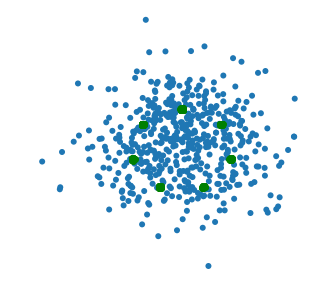

 10%|▉         | 1000/10001 [01:11<10:35, 14.17it/s]

1000 [D loss: -0.194864] [G loss: -3.012801]


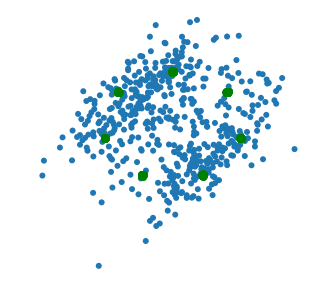

 20%|█▉        | 2000/10001 [02:22<09:32, 13.98it/s]

2000 [D loss: -0.705274] [G loss: -1.596865]


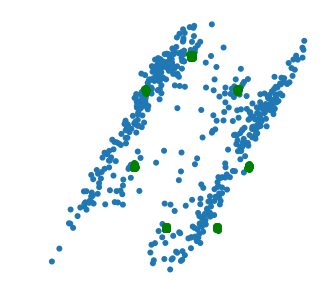

 30%|██▉       | 3000/10001 [03:34<07:59, 14.59it/s]

3000 [D loss: -2.361956] [G loss: -2.542936]


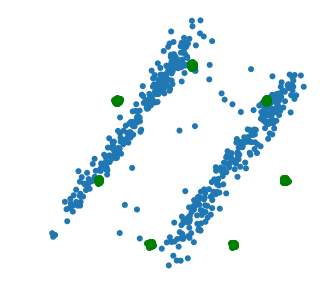

 40%|███▉      | 4000/10001 [04:43<07:30, 13.33it/s]

4000 [D loss: -4.969012] [G loss: 0.136774]


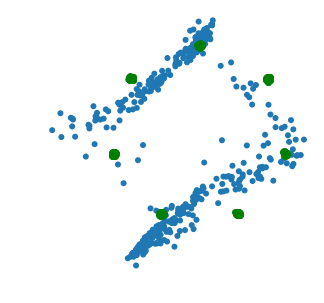

 50%|████▉     | 5000/10001 [05:55<05:50, 14.26it/s]

5000 [D loss: -0.507251] [G loss: -5.674582]


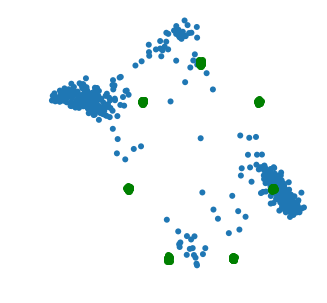

 60%|█████▉    | 6000/10001 [07:05<04:36, 14.48it/s]

6000 [D loss: -6.160963] [G loss: -3.215870]


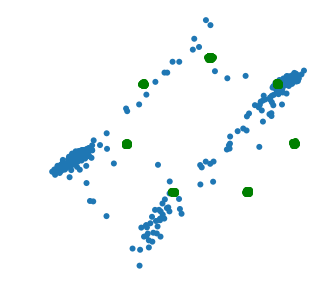

 70%|██████▉   | 7000/10001 [08:16<03:25, 14.60it/s]

7000 [D loss: -8.062893] [G loss: -0.133767]


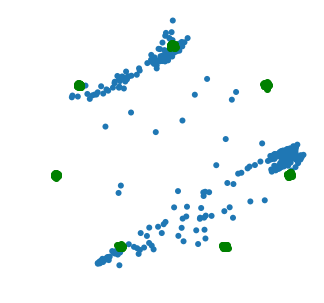

 80%|███████▉  | 8000/10001 [09:27<02:21, 14.13it/s]

8000 [D loss: -8.635118] [G loss: 0.462473]


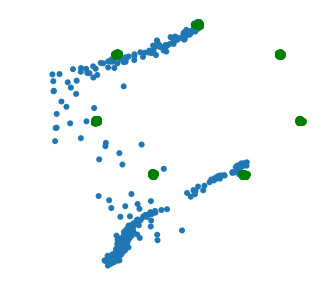

 90%|████████▉ | 9000/10001 [10:40<01:13, 13.59it/s]

9000 [D loss: -11.175577] [G loss: 2.065953]


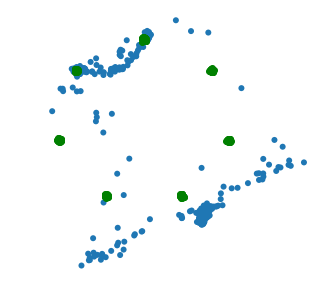

100%|█████████▉| 10000/10001 [11:51<00:00, 14.29it/s]

10000 [D loss: -10.754807] [G loss: -1.874111]


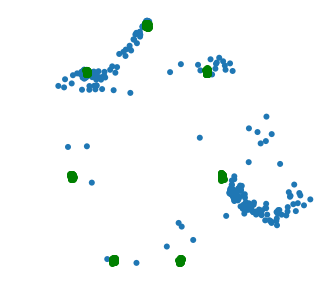

100%|██████████| 10001/10001 [11:52<00:00, 14.05it/s]


In [7]:
%pylab inline
np_samples = gan.train(epochs=10000, batch_size=512, sample_interval=1000)

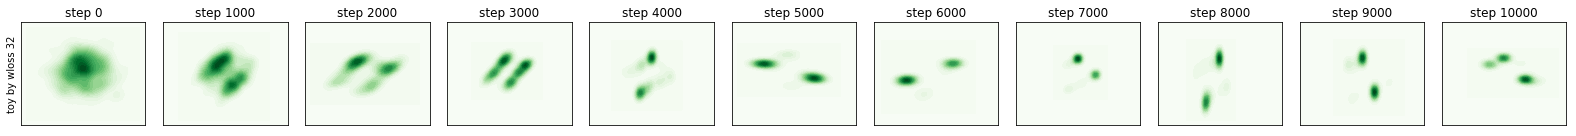

In [9]:
import seaborn as sns
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-3, 3]]*2)
    ax2.set_facecolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*1000))
ax.set_ylabel('toy by wloss 32')
gcf().tight_layout()